In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [2]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

def create_model(hl = 2, hu = 100, dropout = False, rate = 0.3, regularize = False,
                 reg = l1(0.0005), optimizer = Adam(learning_rate = 0.0001), input_dim = None):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim = input_dim, activity_regularizer = reg ,activation = "relu", kernel_regularizer=l2(0.001), ))
    if dropout: 
        model.add(Dropout(rate, seed = 100))
    for layer in range(hl):
        model.add(Dense(hu, activation = "relu", activity_regularizer = reg, kernel_regularizer=l2(0.001),))
        if dropout:
            model.add(Dropout(rate, seed = 100))
    model.add(Dense(1, activation = "sigmoid"))
    
    
    
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [3]:
symbol = "EURUSD=X"
#start = "2022-08-27"
start = "2022-08-28"
end = "2024-08-22"
interval = '1h'
ptc = 0.000059

In [4]:
df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)
features = ["dir", 'Open', 'High', 'Low', 'Close', 'returns']

[*********************100%%**********************]  1 of 1 completed


In [5]:
import warnings
warnings.filterwarnings("ignore")

resultsDf = pd.DataFrame(columns=['lag', 'result', 'cagr', 'num_trades'])

for lag in range(1,48):
    copy = df.copy()
    cols = []
    for f in features:
        for lag in range(1, lag + 1):
            col = "{}_lag_{}".format(f, lag)
            copy[col] = copy[f].shift(lag)
            cols.append(col)
    copy.dropna(inplace=True)
    cols.append('day_of_week')
    split = int(len(copy)* 0.8)
    train = copy.iloc[:split].copy()
    test = copy.iloc[split:].copy()
    mu, std = train.mean(), train.std()
    train_standardized = (train-mu) / std
    
    optimizer = Adam(learning_rate = 0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    set_seeds(100)

    model = create_model(hl=2, hu=64, dropout= True, input_dim=len(cols), optimizer=optimizer)
    model.fit(x=train_standardized[cols], y=train['dir'], epochs=50, verbose=False,
              validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )
    
    model.evaluate(train_standardized[cols], train['dir'])
    predict = model.predict(train_standardized[cols])
    
    test_standardized = (test-mu) / std
    model.evaluate(test_standardized[cols], test['dir'])
    test['probability'] = model.predict(test_standardized[cols])
    threshold = 0.53
    test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
    test['position'] = np.where(test.probability > threshold, 1, test.position)
    test['position'] = test.position.ffill()
    test['strategy'] = test['position'] * test['returns']
    test['creturns'] = test['returns'].cumsum().apply(np.exp)
    test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
    test['trades'] = test.position.diff().abs()
    test['strategy_net'] = test.strategy - test.trades * ptc
    test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)
    
    
    
    
    resultDict =  { 
        'lag': lag, 'result': test['cstrategy'].iloc[-1], 'cagr': test[['strategy_net']].mean() * 252, 'num_trades': test['trades'].sum()
    }
    resultsDf.loc[len(resultsDf)] = resultDict

    

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.5246 - loss: 0.7183
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.5326 - loss: 0.7177
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.5212 - loss: 0.7248
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.5499 - loss: 0.7247
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.5265 - loss: 0.7317
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5261 - loss: 0.7319
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.5234 - loss: 0.7342
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5434 - loss: 0.7342
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0

In [6]:
resultsDf

,lag,result,cagr,num_trades
0,1,1.034818,strategy_net 0.004074 dtype: float64,0.0
1,2,1.038389,strategy_net 0.00401 dtype: float64,0.0
2,3,1.034818,strategy_net 0.004074 dtype: float64,0.0
3,4,0.976037,strategy_net -0.004545 dtype: float64,0.0
4,5,0.969176,strategy_net -0.00633 dtype: float64,0.0
5,6,1.040955,strategy_net 0.005315 dtype: float64,0.0
6,7,1.026117,strategy_net 0.002733 dtype: float64,40.0
7,8,1.029907,strategy_net 0.003156 dtype: float64,0.0
8,9,1.031313,strategy_net 0.003102 dtype: float64,10.0
9,10,1.039170,strategy_net 0.004181 dtype: float64,0.0


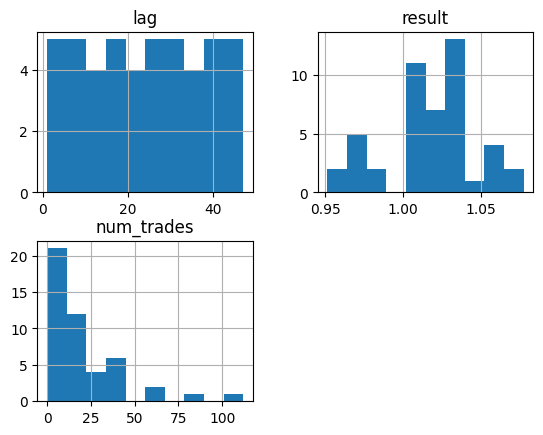

In [7]:
resultsDf.hist()
plt.show()

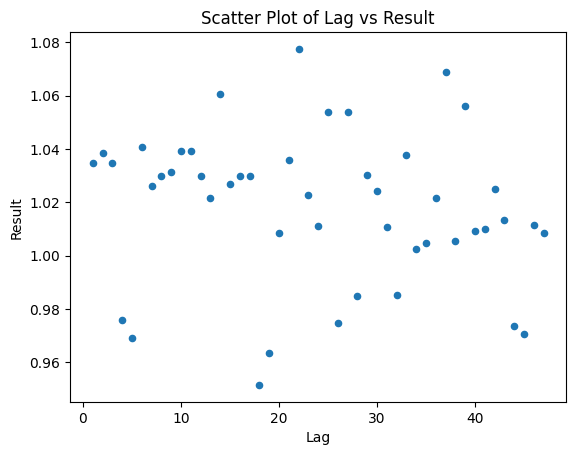

In [8]:
resultsDf.plot(kind='scatter', x='lag', y='result')
plt.title('Scatter Plot of Lag vs Result')
plt.xlabel('Lag')
plt.ylabel('Result')
plt.show()

In [9]:
resultsDf['result'].corr(resultsDf['lag'])

-0.1701162603963313

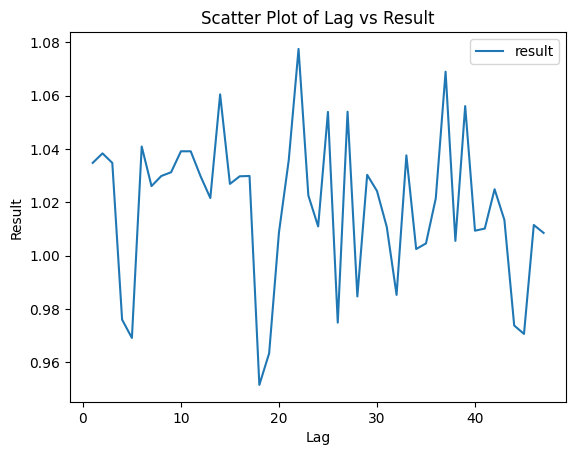

In [10]:
resultsDf.plot(kind='line', x='lag', y='result')
plt.title('Scatter Plot of Lag vs Result')
plt.xlabel('Lag')
plt.ylabel('Result')
plt.show()

In [11]:
train['probability'] = model.predict(train_standardized[cols])
threshold = 0.53
train['position'] = np.where(train.probability < (1-threshold), -1, np.nan)
train['position'] = np.where(train.probability > threshold, 1, train.position)
train['position'] = train.position.ffill()
train['strategy'] = train['position'] * train['returns']
train['creturns'] = train['returns'].cumsum().apply(np.exp)
train['cstrategy'] = train['strategy'].cumsum().apply(np.exp)
train['trades'] = train.position.diff().abs()
train['strategy_net'] = train.strategy - train.trades * ptc
train['cstrategy_net'] = train['strategy_net'].cumsum().apply(np.exp)


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


<Axes: xlabel='Datetime'>

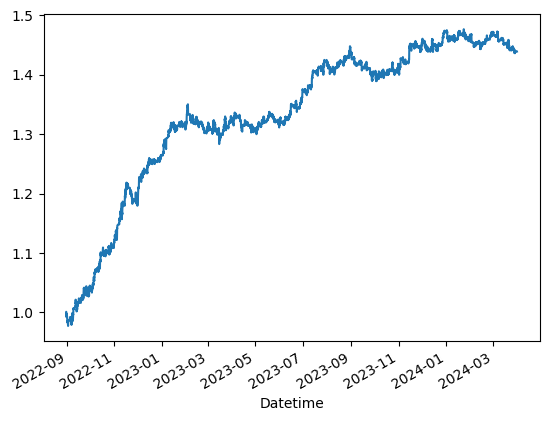

In [12]:
train.cstrategy_net.plot()

<Axes: xlabel='Datetime'>

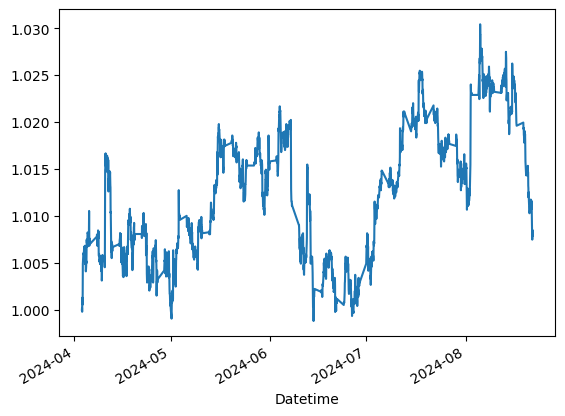

In [13]:
test.cstrategy_net.plot()